# QuaSaR: Identifying EEW Rings - Picking Algorithms

In the efforts to understand the GeoNet datasets for havesting data that can be used in trialing the picking agorithms, we begin with the [GeoNet Strong Motion Database](https://www.geonet.org.nz/data/supplementary/nzsmdb), [rupture  model data](), and [processed recordings]() that are readily available<sup>[1](#myftnote1)</sup>. The idea is to classify the historic data by the various measures made available throught the datasets. Some of the measures include the moment magnitude, hycenter location, measuring station locations, tectonic type, rupture length, total duration, and so on.

We are investigating the use of pytorch and tensor products and their capabilties to build a model for evaluating Objective II.B. For such we need to achieve the following steps
1. Encode or vectorize the data; especially with transforming categorical labels to numerical data
1. [Split the data](https://palikar.github.io/posts/pytorch_datasplit/) to generate training, test, and validation datasets
1. Transform them into tensors as inputs for the model

<a name="ftnote1">[1]</a>: All data and images are made available free of charge through the GeoNet project to facilitate research into hazards and assessment of risk. GeoNet is sponsored by the New Zealand Government through its agencies: Earthquake Commission (EQC), GNS Science and Land Information New Zealand (LINZ), the National Emergency Management Agency (NEMA) and the Ministry of Business, Innovation and Employment (MBIE).

In [34]:
'''
    WARNING CONTROL to display or ignore all warnings
'''
import warnings; warnings.simplefilter('ignore')     #switch betweeb 'default' and 'ignore'

/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
'''
    Train-Validation-Test split in PyTorch - The Data Split Class
    blog post: https://palikar.github.io/posts/pytorch_datasplit/#the-datasplit-class
    By  Stanislav Arnaudov https://www.linkedin.com/in/stanislav-arnaudov-37b475164/
    consulted 2021-Jan-07 on the web: https://palikar.github.io/posts/pytorch_datasplit/#the-datasplit-class
'''
import logging
from functools import lru_cache

import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler

import numpy as np

class DataSplit:

    def __init__(self, dataset, test_train_split=0.8, val_train_split=0.3, shuffle=False):
        self.dataset = dataset

        dataset_size = len(self.dataset)
        self.indices = list(range(dataset_size))
        test_split = int(np.floor(test_train_split * dataset_size))

        if shuffle:
            np.random.shuffle(self.indices)

        train_indices, self.test_indices = self.indices[:test_split], self.indices[test_split:]
        train_size = len(train_indices)
        validation_split = int(np.floor((1 - val_train_split) * train_size))
        self.train_indices, self.val_indices = train_indices[ : validation_split], train_indices[validation_split:]
        
        self.train_sampler = SubsetRandomSampler(self.train_indices)
        self.val_sampler = SubsetRandomSampler(self.val_indices)
        self.test_sampler = SubsetRandomSampler(self.test_indices)
        
#        print(f"length of train sampler: {str(len(self.train_sampler))}, val sampler {str(len(self.val_sampler))}, and test sampler {str(len(self.test_sampler))}")
#        print(f"Training sampler:\n{self.train_sampler.indices[0:9]}\nValidation sampler:\n{self.val_sampler.indices[0:9]}\nTest sampler:\n{self.test_sampler.indices[0:9]}")
        
    def get_train_split_point(self):
        return len(self.train_sampler) + len(self.val_indices)

    def get_validation_split_point(self):
        return len(self.train_sampler)

    @lru_cache(maxsize=4)
    def get_split(self, batch_size=50, num_workers=4):
        logging.debug('Initializing train-validation-test dataloaders')
        self.train_loader = self.get_train_loader(batch_size=batch_size, num_workers=num_workers)
        self.val_loader = self.get_validation_loader(batch_size=batch_size, num_workers=num_workers)
        self.test_loader = self.get_test_loader(batch_size=batch_size, num_workers=num_workers)
        return self.train_loader, self.val_loader, self.test_loader

    @lru_cache(maxsize=4)
    def get_train_loader(self, batch_size=50, num_workers=4):
        logging.debug('Initializing train dataloader')
        self.train_loader = torch.utils.data.DataLoader(self.dataset, batch_size=batch_size, sampler=self.train_sampler, shuffle=False, num_workers=num_workers)
        return self.train_loader

    @lru_cache(maxsize=4)
    def get_validation_loader(self, batch_size=50, num_workers=4):
        logging.debug('Initializing validation dataloader')
        self.val_loader = torch.utils.data.DataLoader(self.dataset, batch_size=batch_size, sampler=self.val_sampler, shuffle=False, num_workers=num_workers)
        return self.val_loader

    @lru_cache(maxsize=4)
    def get_test_loader(self, batch_size=50, num_workers=4):
        logging.debug('Initializing test dataloader')
        self.test_loader = torch.utils.data.DataLoader(self.dataset, batch_size=batch_size, sampler=self.test_sampler, shuffle=False, num_workers=num_workers)
        return self.test_loader

## Hueristically mining the strong motion database

[Flatfile specifications](https://static.geonet.org.nz/info/resources/applications_data/earthquake/strong_motion/Flatfiles_ColumnExplanation.pdf). They contain the horizontal and vertical acceleration response spectra, and horizontal and vertical Fourier amplitude spectra of acceleration.

In [47]:
import torch
import pandas as pd
#import sklearn.preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

'''
    CSV LOAD into DataFrame and remove unnecessary columns
'''
strong_motion_df = pd.read_csv('../data/flatfiles/NZdatabase_flatfile_Significant_Duration_horizontal.csv', encoding = "UTF-8")

strong_motion_df = strong_motion_df.drop(columns=['References','Location'], axis=1)
strong_motion_df = strong_motion_df.replace('>2',float(2.1))
strong_motion_df = strong_motion_df.replace('<0.1',float(0.1))

_lst_categorical_data = ['CuspID','Origin_time','Record','TectClass','Mech','HWFW','SiteCode','SiteClass1170',
                         'Vs30Uncert','TsiteUncert','Z1Uncertainty']]

'''
    LabelEncoder to convert the categorical data to numerical float64
'''
le = LabelEncoder()
strong_motion_df['CuspID']= le.fit_transform(strong_motion_df['CuspID']).astype(float) 
strong_motion_df['Origin_time']= le.fit_transform(strong_motion_df['Origin_time']).astype(float) 
strong_motion_df['Record']= le.fit_transform(strong_motion_df['Origin_time']).astype(float) 
strong_motion_df['TectClass']= le.fit_transform(strong_motion_df['TectClass']).astype(float) 
strong_motion_df['Mech']= le.fit_transform(strong_motion_df['Mech']).astype(float) 
strong_motion_df['HWFW']= le.fit_transform(strong_motion_df['TectClass']).astype(float) 
strong_motion_df['SiteCode']= le.fit_transform(strong_motion_df['Mech']).astype(float) 
strong_motion_df['SiteClass1170']= le.fit_transform(strong_motion_df['CuspID']).astype(float) 
strong_motion_df['Vs30Uncert']= le.fit_transform(strong_motion_df['Origin_time']).astype(float) 
strong_motion_df['TsiteUncert']= le.fit_transform(strong_motion_df['TectClass']).astype(float) 
strong_motion_df['Z1Uncertainty']= le.fit_transform(strong_motion_df['Mech']).astype(float)
print(f"Shape of the DataFrame: {strong_motion_df.shape}")

Shape of the DataFrame: (4291, 57)


   CuspID  Origin_time  Record    Mw  MwUncert  TectClass  Mech  \
0     6.0          0.0     0.0  5.70      0.15        0.0   3.0   
1     8.0          2.0     2.0  5.62      0.15        2.0   0.0   
2     8.0          2.0     2.0  5.62      0.15        2.0   0.0   

   PreferredFaultPlane  Strike  Dip  ...  TotalDuration  D5_75_H1_sec  \
0                    1     242   83  ...          42.09          3.96   
1                    1     250   56  ...          25.96          3.22   
2                    1     250   56  ...          52.58          2.63   

   D5_75_H2_sec  D5_75_GM_sec  D5_95_H1_sec  D5_95_H2_sec  D5_95_GM_sec  \
0          3.33          3.63         12.02         11.29         11.65   
1          2.09          2.59          6.90          6.19          6.54   
2          5.92          3.95         10.94         14.93         12.78   

   D20_80_H1_sec  D20_80_H2_sec  D20_80_GM_sec  
0           3.93           2.83           3.33  
1           2.84           2.43        

Text(0.5, 0.98, 'Pair Plots for relevant measures')

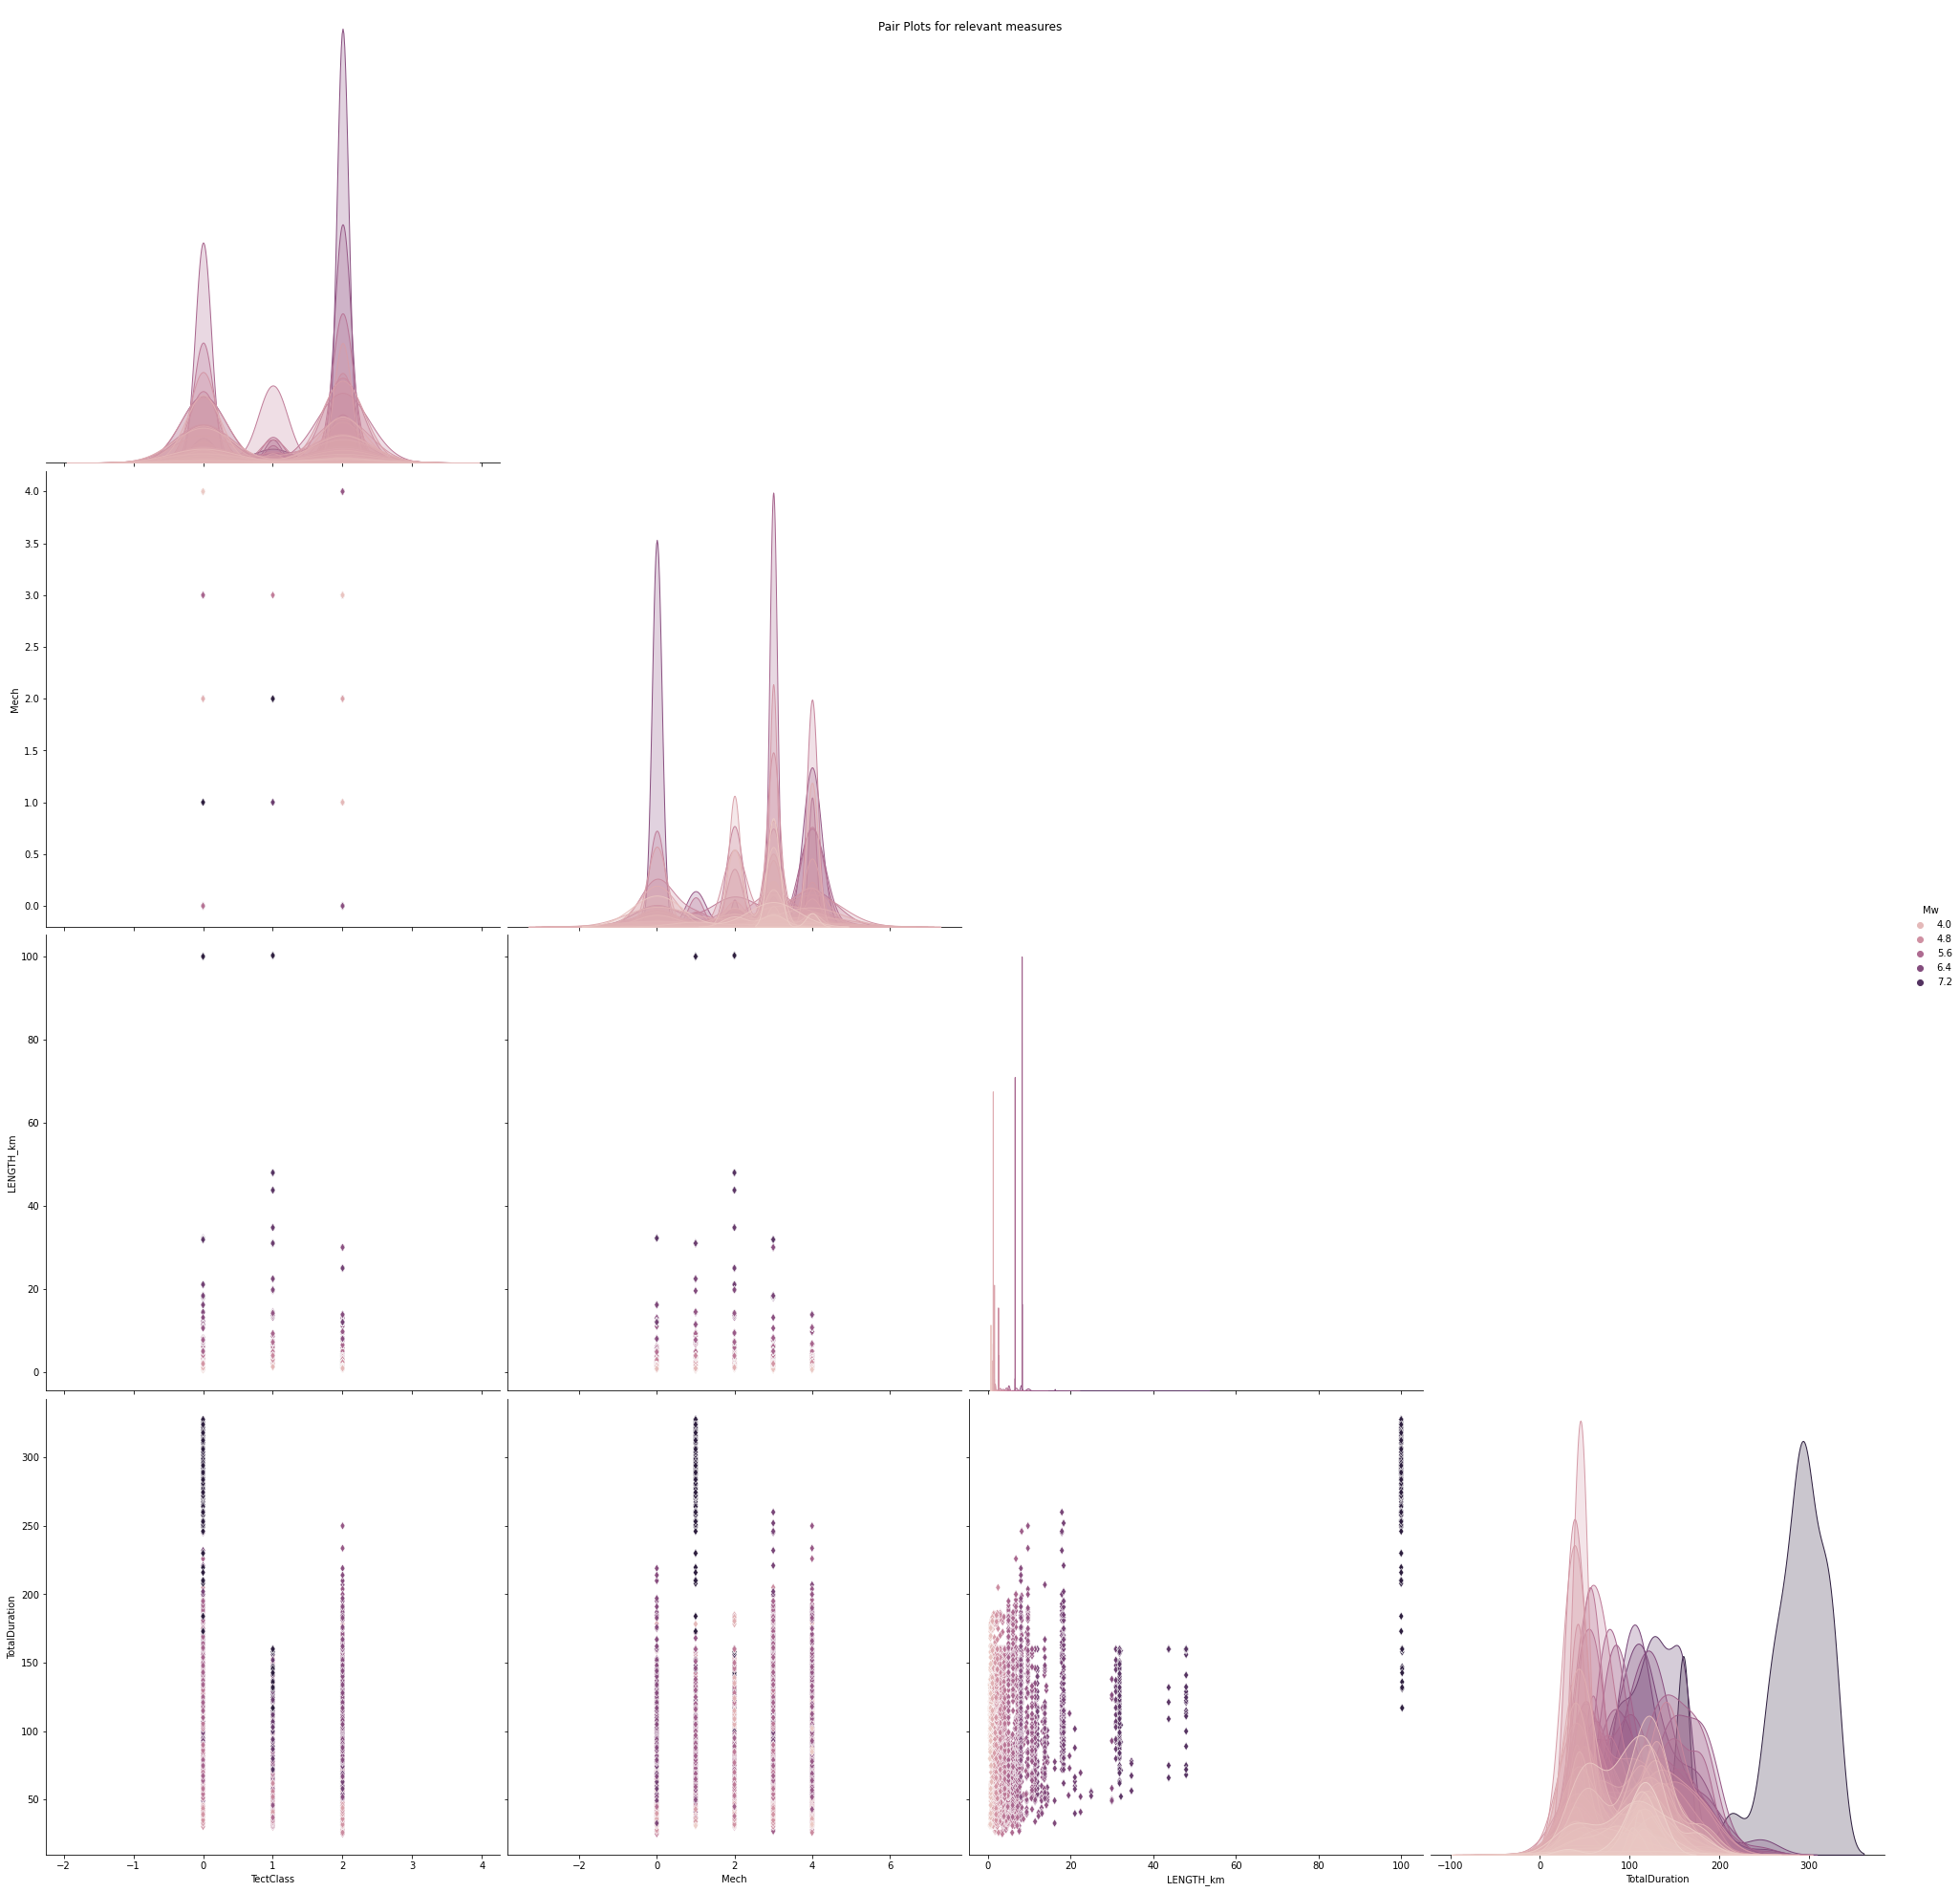

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
print(strong_motion_df.head(3))
'''
    Pairwise density plots for all the column variables
    attribute specs: https://static.geonet.org.nz/info/resources/applications_data/earthquake/strong_motion/Flatfiles_ColumnExplanation.pdf
'''
plot_df = strong_motion_df[['Mw',          # Moment Magnitude
                            'MwUncert',    # Mw uncertainty class 
                            'TectClass',   # Tectonic classification, either ‘crustal’, ‘interface’, or ‘slab’
                            'Mech',        # Focal mechanism: S→strike-slip, N→normal,R→reverse,U→unknown
                            'PreferredFaultPlane', # 1→one fault plane orientation is preferred, 1→Unknown
                            'Strike',      # Strike angle (degrees)
                            'Dip',         # Dip angle (degrees)
                            'Rake',        # Rake angle (degrees)
                            'HypLat',      # Hypercenter Latitude
                            'HypLon',      # Hypercernter Longitude
                            'StationLat',  # Recording Station Latitude
                            'StationLon',  # Recording Station Longitude
                            'HypN',        # Northing of Hyppercenter
                            'HypE',        # Easting of Hypercernter
                            'StationN',    # Northing of Station
                            'StationE',    # Easting of Station
                            'LENGTH_km',   # Infered rupture Length in Kilometers
                            'WIDTH_km',    # Infered down-dip rupture Width in Kilometers
                            'TotalDuration'# Total Duration of the earthquake
                           ]]

print(f"Variance of each measure: \n{pd.DataFrame(plot_df[['Mw','TectClass','Mech','LENGTH_km','TotalDuration']].describe()).T}")
g = sns.pairplot(plot_df[['Mw','TectClass','Mech','LENGTH_km','TotalDuration']], 
             hue='Mw', corner=True,hue_order=None,
             kind='scatter', diag_kind='auto', height=7,markers='d')
g.fig.suptitle("Pair Plots for relevant measures") # y= some height>1


In [8]:
'''
    DATASPLIT the dataset to generate training, test, and validation DataLoaders
    TODO: fix the split ratio, currently it's the same size for all three train, val, & test
'''
#train_set, test_set = torch.utils.data.random_split(train_1hotenc, [int(len(train_1hotenc)*.9), int(len(train_1hotenc)*.1)])
split = DataSplit(strong_motion_df, test_train_split=0.8, val_train_split=0.3, shuffle=False)
print(f"Sampler training dataset head: {split.train_sampler.indices[0:9]}")
print(f"Sampler validation dataset head: {split.val_sampler.indices[0:9]}")
print(f"Sampler testing dataset head: {split.test_sampler.indices[0:9]}")

Sampler training dataset head: [0, 1, 2, 3, 4, 5, 6, 7, 8]
Sampler validation dataset head: [2402, 2403, 2404, 2405, 2406, 2407, 2408, 2409, 2410]
Sampler testing dataset head: [3432, 3433, 3434, 3435, 3436, 3437, 3438, 3439, 3440]


### Convert datasets to tensors

In [117]:
'''
    TENSOR formulation of the train, test, and validation datasets
'''
train_loader, val_loader, test_loader = split.get_split(batch_size=50, num_workers=0)
print("\nData types of the * loader dataset")
print(f"\n{train_loader.dataset.dtypes}")

'''
    Remove header by starting sampler from index = 1
    Get DataLoader data subset with corresponding indeces
'''
#print(train_loader.dataset[:[1,9]])
train_df = train_loader.dataset.loc[split.train_sampler.indices[1:]]
val_df = val_loader.dataset.loc[split.val_sampler.indices[1:]]
test_df = test_loader.dataset.loc[split.test_sampler.indices[1:]]
print(f"\nShapes of the train: {train_df.shape}, validation: {val_df.shape}, and test: {test_df.shape} dataframes")
#transform = torch.transforms.Compose([transforms.ToTensor(), 
#                                        transforms.Normalize((0.5,), (0.5,))])
sample_train_ts = torch.tensor(np.array([train_df], dtype=np.float32))
sample_val_ts = torch.tensor(np.array([val_df], dtype=np.float32))
sample_test_ts = torch.tensor(np.array([test_df], dtype=np.float32))
print(f"\nShape of training tensor {sample_train_ts.shape} data type {sample_train_ts.dtype} running on {sample_train_ts.device}")
print(sample_train_ts)
print(f"\nShape of validation tensor: {sample_val_ts.shape} data type {sample_val_ts.dtype} running on {sample_val_ts.device}")
print(sample_val_ts)
print(f"\nShape of test tensor {sample_test_ts.shape} data type {sample_test_ts.dtype} running on {sample_test_ts.device}")
print(sample_test_ts)


Data types of the * loader dataset

CuspID                 float64
Origin_time            float64
Record                 float64
Mw                     float64
MwUncert               float64
TectClass              float64
Mech                   float64
PreferredFaultPlane      int64
Strike                   int64
Dip                      int64
Rake                   float64
HypLat                 float64
HypLon                 float64
StationLat             float64
StationLon             float64
HypN                   float64
HypE                   float64
StationN               float64
StationE               float64
LENGTH_km              float64
WIDTH_km               float64
Repi_km                float64
Rhyp_km                float64
Rjb_km                 float64
Rrup_km                float64
Rx_km                  float64
Ry_km                  float64
Rvol_km                  int64
HypDepth_km            float64
ZTOR_km                float64
HWFW                   float64
Si

### NN Classification of Strong Motion DB
Look at some of the properties starting with a [simple nn classifier](https://stackabuse.com/introduction-to-pytorch-for-classification/).

In [106]:
import torch.nn as nn
import torch.optim as optim

class Net(nn.Module):

    def __init__(self, embedding_size, num_numerical_cols, output_size, layers, p=0.4):
        super().__init__()
        self.all_embeddings = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in embedding_size])
        self.embedding_dropout = nn.Dropout(p)
        self.batch_norm_num = nn.BatchNorm1d(num_numerical_cols)

        all_layers = []
        num_categorical_cols = sum((nf for ni, nf in embedding_size))
        input_size = num_categorical_cols + num_numerical_cols

        for i in layers:
            all_layers.append(nn.Linear(input_size, i))
            all_layers.append(nn.ReLU(inplace=True))
            all_layers.append(nn.BatchNorm1d(i))
            all_layers.append(nn.Dropout(p))
            input_size = i

        all_layers.append(nn.Linear(layers[-1], output_size))

        self.layers = nn.Sequential(*all_layers)

    def forward(self, x_categorical, x_numerical):
        embeddings = []
        for i,e in enumerate(self.all_embeddings):
            embeddings.append(e(x_categorical[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.embedding_dropout(x)

        x_numerical = self.batch_norm_num(x_numerical)
        x = torch.cat([x, x_numerical], 1)
        x = self.layers(x)
        return x

### The Model

In [107]:
embedding_size=        # embedding_size: Contains the embedding size for the categorical columns
num_numerical_cols=    # num_numerical_cols: Stores the total number of numerical columns
output_size=           # output_size: The size of the output layer or the number of possible outputs.
layers=                # layers: List which contains number of neurons for all the layers.
p=0.4                  # p: Dropout with the default value of 0.5
model = Net(embedding_size, num_numerical_cols, output_size, layers, p=0.4) # On CPU
#model = Net().to(device)  # On GPU
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

outputs = ['Exited']
outputs = torch.tensor(dataset[outputs].values).flatten()

TypeError: __init__() missing 4 required positional arguments: 'embedding_size', 'num_numerical_cols', 'output_size', and 'layers'

## Objective II.B - Test with Machine Learning 

Apply earthquake picking algorithms on the GeoNet wave form data and test them with new machine learning and wavefield algorithms (e.g. , 8bit Picking, PLUM, and so on). Thereafter, make use of those to test selected above picking algorithms with simulated earthquakes and for selected high risk faults to observe the response of the picking algorithms (i.e. performance)


### OneHotEncoding [DEPRECATE?]

In [65]:
'''
    DEPRECATE if the LabelEncoding is sufficient; else,
    TODO: OneHotEncode before building the the tensors
'''

import logging
from functools import lru_cache

logging.debug('Preprocessing data with OneHotEncoder')

'''
    OneHotEncoder to create the arrays for training, validation, and testing
'''
train_1hotenc = np.empty_like(train_ts)
for t_indx, t in enumerate(train_ts):
    print(t_indx,t.numpy())
    train_1hotenc[t_indx] = OneHotEncoder(categories='auto', drop=None, sparse=True, dtype='float64', 
                                  handle_unknown='error').fit_transform(t.numpy())
    print(train_1hotenc[t_indx])
train_1hotenc_ts = train_1hotenc
print(f"Shape of the OneHotencoded array: {train_1hotenc.shape}")
print(f"Datatype of the OneHotencoded array: {train_1hotenc.dtype}")

0 [[  8.      2.      2.    ...   2.84    2.43    2.63 ]
 [  8.      2.      2.    ...   2.67    5.69    3.9  ]
 [  9.      3.      3.    ...   3.08    3.9     3.47 ]
 ...
 [ 31.    219.    219.    ...  10.27    4.425   6.74 ]
 [ 31.    219.    219.    ...  11.475  13.33   12.37 ]
 [ 31.    219.    219.    ...   8.39    9.29    8.83 ]]


ValueError: setting an array element with a sequence.